In [2]:
import os
import pandas  as pd #Data manipulation
import numpy as np #Data manipulation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/datasets/

Mounted at /content/drive
/content/drive/My Drive/datasets


Based on the analysis from https://www.kaggle.com/code/sudhirnl7/linear-regression-tutorial

In [56]:
# Load data
df_raw = pd.read_csv('insurance.csv')

# Data exploration

In [57]:
print(df_raw.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [58]:
# Data exploration
#  Start by understanding the data (categorical vs. numeric, what's the range ie. min() and max())
print(df_raw.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


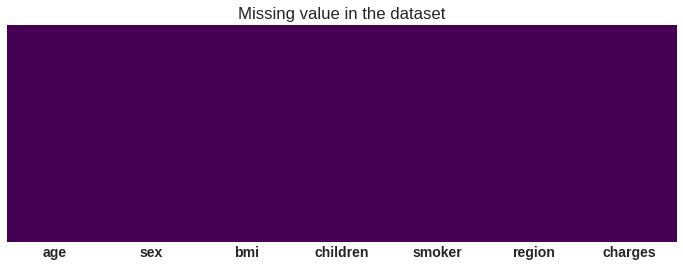

In [59]:
# Check for missing values
plt.figure(figsize=(12,4))
sns.heatmap(df_raw.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

# No missing values!

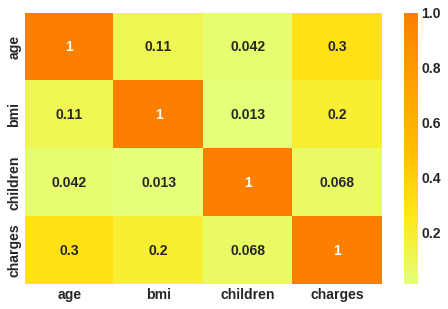

In [60]:
# Check for correlated variables
corr = df_raw.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True);

# There doesn't seem to be any correlation between quantitative variables

Let's take a look at how our target variable behaves when segmented by our categorical variables

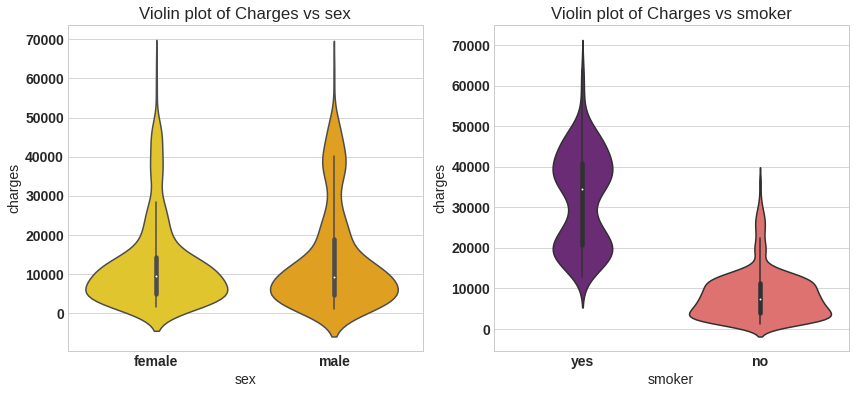

In [61]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.violinplot(x='sex', y='charges',data=df_raw,palette='Wistia',ax=ax)
ax.set_title('Violin plot of Charges vs sex')

ax = f.add_subplot(122)
sns.violinplot(x='smoker', y='charges',data=df_raw,palette='magma',ax=ax)
ax.set_title('Violin plot of Charges vs smoker');

There's definitely a difference between the charges for smokers vs non-smokers. Gender doesn't seem to be too significant in terms of charges.

Next let's see how # of children affects the target variable:

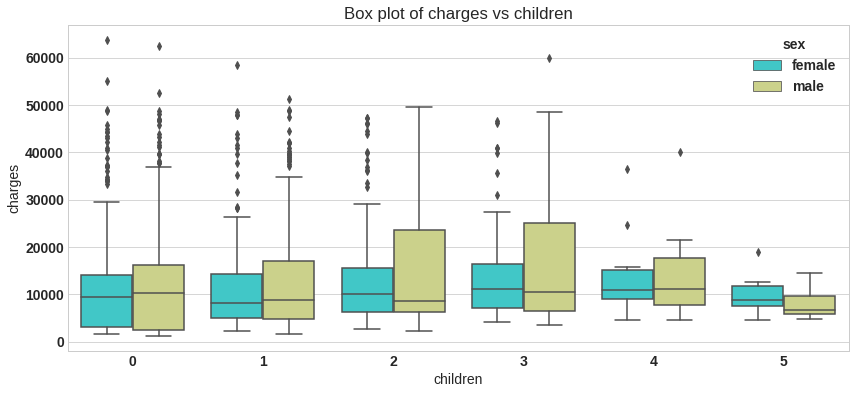

In [62]:
plt.figure(figsize=(14,6))
sns.boxplot(x='children', y='charges',hue='sex',data=df_raw,palette='rainbow')
plt.title('Box plot of charges vs children');

In [63]:
print(df_raw['children'].value_counts())

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64


Number of children doesn't seem to be significant, although there's some bias for samples where [# of children >= 4], although this might be caused by a smaller amount of samples for the latter ones. If this is the case, we might want to explore including all samples where [# of children] >= 3 in a single categorical bucket ("3 or more").

In [65]:
df_raw['children_bucket'] = np.where(df_raw['children'] == 0, 'child0',
                        np.where(df_raw['children'] == 1, 'child1', 
                        np.where(df_raw['children'] == 2, 'child2', 'child3+')))

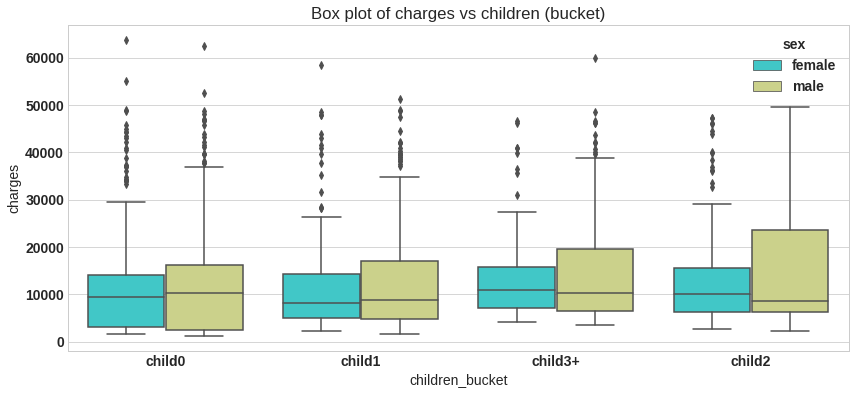

In [66]:
plt.figure(figsize=(14,6))
sns.boxplot(x='children_bucket', y='charges',hue='sex',data=df_raw,palette='rainbow')
plt.title('Box plot of charges vs children (bucket)');

As expected, we have only a very small sample for values higher than 3 in [# of children] variable, so we'll explore creating a categorical variable out of the [children] original variable. This we'll explore after fitting our first model without any feature engineering.

Finally, let's explore some relationships between our quantitative variables, including a color dimension for our categorical variables: 

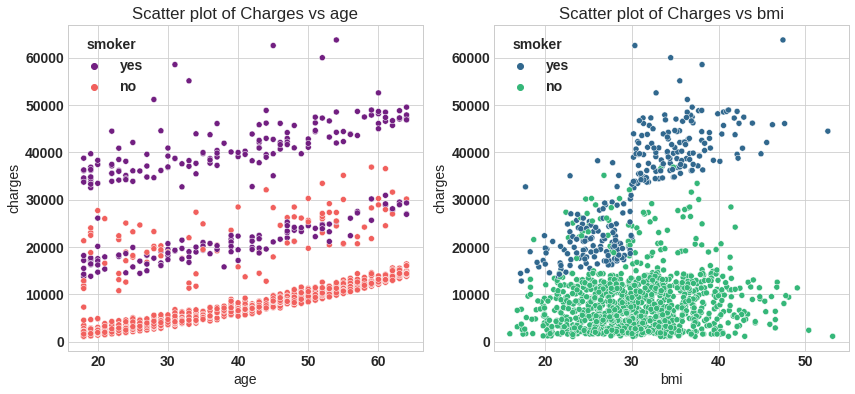

In [67]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='charges',data=df_raw,palette='magma',hue='smoker',ax=ax)
ax.set_title('Scatter plot of Charges vs age')

ax = f.add_subplot(122)
sns.scatterplot(x='bmi',y='charges',data=df_raw,palette='viridis',hue='smoker')
ax.set_title('Scatter plot of Charges vs bmi')
plt.savefig('sc.png');

There's a clear interaction between [smoker] and [bmi] that we'll want to include into the model. On the other hand there's a clear separation _within_ the smoker variable that is causing two clusters in charges. Otherwise it seems like there's a positive correlation between [age] and the target variable [charges] which seems to be pretty consistent among the different clusters (non-smokers, smokers cluster 1, and smokers cluster 2).

What could be causing this separation in the smokers group along the [charges] variable? As can be seen from the plot on the right, it seems like there's a hard cut between bmi less than 30 and bmi more than 30, so it might be a good idea to include such a variable into our model upfront. (In practice this is the kind of insights you'd get from the business understanding part of the data science pipeline).

In [68]:
df_raw['bmi_more_than_30'] = np.where(df_raw['bmi'] < 30, 0, 1)

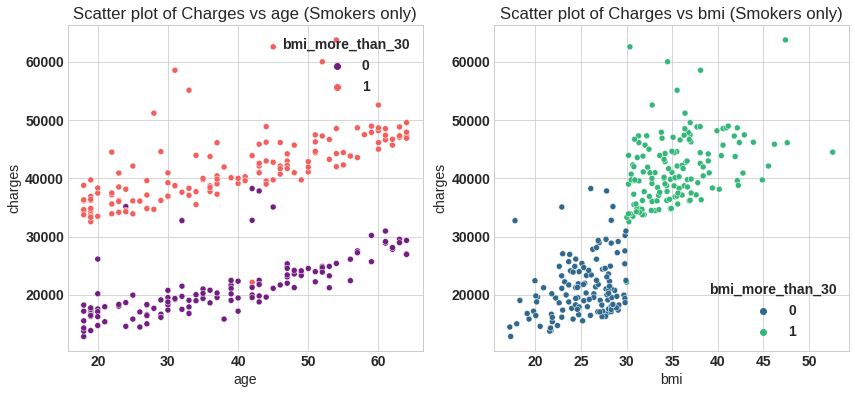

In [69]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='charges',data=df_raw[df_raw.smoker == "yes"],palette='magma',hue='bmi_more_than_30',ax=ax)
ax.set_title('Scatter plot of Charges vs age (Smokers only)')

ax = f.add_subplot(122)
sns.scatterplot(x='bmi',y='charges',data=df_raw[df_raw.smoker == "yes"],palette='viridis',hue='bmi_more_than_30')
ax.set_title('Scatter plot of Charges vs bmi (Smokers only)')
plt.savefig('sc.png');

For the non-smoker population, there's a set of points that clearly deviates from the overall population. By plotting with different color codes (out of the categorical variables), there's no clear criteria to tell them appart from the main cloud of points:

Text(0.5, 1.0, 'Scatter plot of Charges vs age')

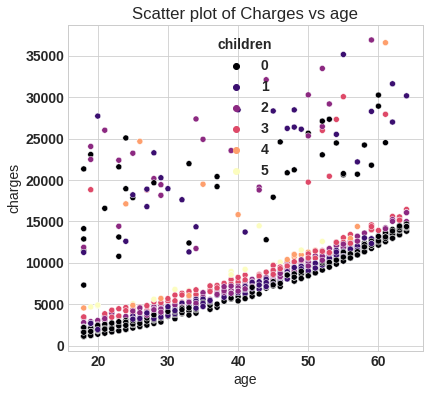

In [70]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='charges',data=df_raw[df_raw.smoker == "no"],palette='magma',hue='children',ax=ax)
ax.set_title('Scatter plot of Charges vs age')

It might be a good idea to separate these points from the data set - in practice you might want to check in with the business to understand why these points differ from the others and this might reveal that we need some more features into our model. For the moment we'll just drop them.

In [71]:
# We'll revisit this problem in the outlier detection module. For the moment let's just apply a simple rule based on the observed values: 

df_raw['outlier'] = (df_raw.charges > 5000 + 15000/70 * df_raw.age) * df_raw.smoker == "no"

Text(0.5, 1.0, 'Scatter plot of Charges vs age')

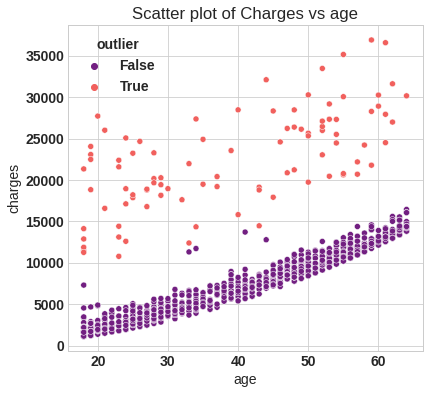

In [72]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='charges',data=df_raw[df_raw.smoker == "no"],palette='magma',hue='outlier',ax=ax)
ax.set_title('Scatter plot of Charges vs age')

In [73]:
df = df_raw[df_raw.outlier == False]

We're now in a good place to try some models!

# Data preprocessing
We'll start by encoding categorical variables and splitting the data into a training set and a validation set:

In [74]:
# Dummy variable
categorical_columns = ['sex','children_bucket', 'smoker', 'region'] # we're not including the [bmi_more_than_30] variable since it's already encoded
df_encode = pd.get_dummies(data = df, prefix = 'cat', prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
               dtype='int8')

In [75]:
print(df_encode.head())

   age    bmi  children     charges  bmi_more_than_30  outlier  cat_male  \
0   19  27.90         0  16884.9240                 0    False         0   
1   18  33.77         1   1725.5523                 1    False         1   
2   28  33.00         3   4449.4620                 1    False         1   
4   32  28.88         0   3866.8552                 0    False         1   
5   31  25.74         0   3756.6216                 0    False         0   

   cat_child1  cat_child2  cat_child3+  cat_yes  cat_northwest  cat_southeast  \
0           0           0            0        1              0              0   
1           1           0            0        0              0              1   
2           0           0            1        0              0              1   
4           0           0            0        0              1              0   
5           0           0            0        0              0              1   

   cat_southwest  
0              1  
1              0  

In [76]:
# Let's include the smoker AND high bmi interaction term
df_encode['cat_smoker_and_bmi30'] = df_encode['cat_yes'] * df_encode['bmi_more_than_30']

In [77]:
# Split data into training and test set
from sklearn.model_selection import train_test_split
X = df_encode.drop('charges',axis=1) # Independet variable
y = df_encode['charges'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23)

# Modeling
We'll try out first an OLS model with interaction between the [smoker] and [bmi_gt_30] variable, and [age].

Then we'll try out a Lasso without any sort of feature selection in order to see if we get the same result or better than the first one.

In [78]:
# Model 1
mod1_features = ['age','cat_yes', 'cat_smoker_and_bmi30']
X_train_1 = X_train[mod1_features]
X_test_1 = X_test[mod1_features]

# Scikit Learn module
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_1,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
#sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
#parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
#parameter_df

LinearRegression()

In [97]:
pd.DataFrame({
    'theta' : np.append(lin_reg.feature_names_in_, 'Intercept'),
    'coeff' : np.append(lin_reg.coef_,lin_reg.intercept_)
})


,theta,coeff
0,age,269.529971
1,cat_yes,14795.120655
2,cat_smoker_and_bmi30,19980.787420
3,Intercept,-3540.370176


In [103]:
my_x = np.array([20,0,0])
my_x
#lin_reg.predict()

array([20,  0,  0])

In [79]:
# Evaluate my model
y_pred_1 = lin_reg.predict(X_test_1)

#   Evaluvation: MSE
from sklearn.metrics import mean_squared_error
J_mse_sk = mean_squared_error(y_pred_1, y_test)
print('R2 on test set: ',  str(lin_reg.score(X_test_1, y_test)))

R2 on test set:  0.9635264680581529


A 96% R2 is pretty good. We'll need to check if our assumptions hold, i.e. linearity, normality of the residuals and homoscedasticity. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


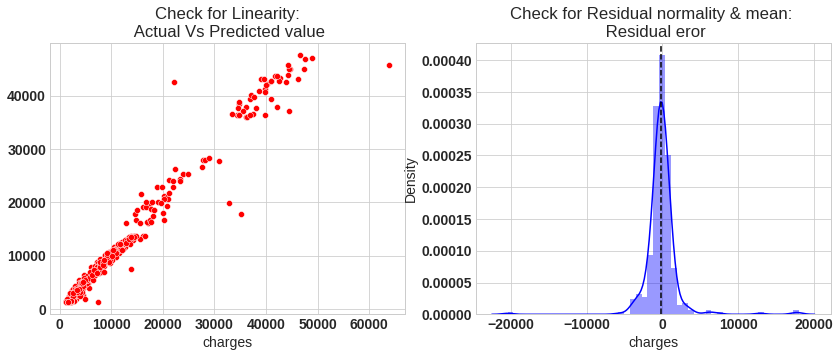

In [80]:
# Let's check out if our assumptions hold via residual analysis
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred_1,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred_1),ax=ax,color='b')
ax.axvline((y_test - y_pred_1).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

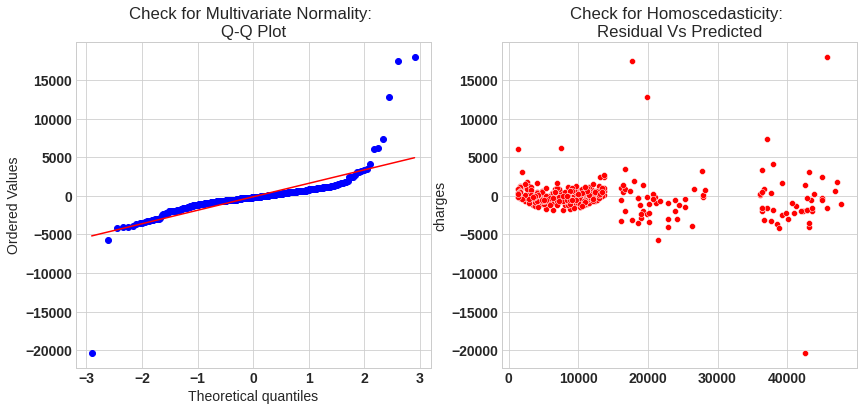

In [81]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - y_pred_1),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y_test - y_pred_1), x= y_pred_1, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

In [108]:
# Check for Multicollinearity
#Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_1.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_1.values, i)
                          for i in range(len(X_train_1.columns))]
  
print(vif_data)

                feature       VIF
0                   age  1.238421
1               cat_yes  2.452127
2  cat_smoker_and_bmi30  2.222361


1. Linearity seems to hold well enough.
2. Our residuals are nicely centered around 0, although there seems to be some outliers, especially a couple of values our model is underestimating.
2. Our residuals are fairly normal, as we can see from the qqplot, with the exception of the outliers we mentiones before. We might want to remove these outliers and fit our model again, then test for normality with a Shapiro Wilk test.
3. Homoscedasticity kind of holds, but there's definitely more variance in both smoker samples (clusters 1 and 2), both with low as well as high bmi.
4. There is no multicolinearity (VIF < 5)

# Lasso model
We'll now try out a Lasso model to see if we can get a model at least as good as the one we developed before. This approach should allow for a more automated approach to variable selection, as well as (hopefully) better generalization over the test set.

Our approach should include:
1. Choosing a regularization hyperparameter with cross-validation
2. Fitting a Lasso model with this hyperparameter.
3. Run the same residua analysis tests.